#### 문제 6-1 : 조건부 분기가 있는 메뉴 추천 시스템 ( LangGraph 사용하기) 
- create_react_agent() 함수를 사용하여 간단하게 구현하셔도 됩니다. 

In [57]:
from dotenv import load_dotenv
load_dotenv()
import re
import os, json

from textwrap import dedent
from pprint import pprint

import uuid

import warnings
warnings.filterwarnings("ignore")

- 백터 저장소 초기화

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_ollama  import OllamaEmbeddings
from langchain_core.tools import tool
from typing import List
from langchain_core.documents import Document

embeddings_model = OllamaEmbeddings(model="qwen2.5:1.5b") 

# menu db 벡터 저장소 로드
cafe_db = FAISS.load_local(
    "../db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)


@tool
def search_menu(query: str) -> List[Document]:
    """카페 메뉴에서 정보를 검색합니다."""
    embeddings_model = OllamaEmbeddings(model="bge-m3:latest")
    cafe_db = FAISS.load_local(
        "../db/cafe_db", 
        embeddings_model, 
        allow_dangerous_deserialization=True
    )

    # 문의 유형별 분기 처리
    if "가격" in query or "얼마" in query:
        docs = cafe_db.similarity_search("메뉴 가격", k=5)
    elif "추천" in query or "추천해줘" in query:
        docs = cafe_db.similarity_search(query, k=3)
        if not docs:
            docs = cafe_db.similarity_search("인기 메뉴", k=3)
    else:
        docs = cafe_db.similarity_search(query, k=4)

    if docs and len(docs) > 0:
        return docs

    return [Document(page_content="관련 카페 메뉴 정보를 찾을 수 없습니다.")]

- Tavily 초기화

In [59]:
from langchain_community.tools import TavilySearchResults

# Tool 정의 
@tool
def search_web(query: str) -> List[str]:
    """데이터베이스에 존재하지 않는 정보 또는 최신 정보를 인터넷에서 검색합니다."""

    tavily_search = TavilySearchResults(max_results=3)
    docs = tavily_search.invoke(query)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."

- LLM과 Tool 연결

In [60]:
from langchain_openai import ChatOpenAI

# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)
print(llm.model_name)

# 도구 목록
tools = [search_menu, search_web]
print(type(search_menu))

# 모델에 도구를 바인딩
llm_with_tools = llm.bind_tools(tools=tools)
print(type(llm_with_tools))

gpt-4o-mini
<class 'langchain_core.tools.structured.StructuredTool'>
<class 'langchain_core.runnables.base.RunnableBinding'>


In [61]:
from langchain_core.messages import HumanMessage

# 도구 호출 ( Vector DB )
tool_call = llm_with_tools.invoke([HumanMessage(content=f"카페 메뉴 중 가장 단 음료 추천해줘")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{'tool_calls': [{'function': {'arguments': '{"query":"단 음료"}',
                              'name': 'search_menu'},
                 'id': 'call_IFJXliCjQ0rNzhlIBCybK3mo',
                 'index': 0,
                 'type': 'function'}]}


- 도구 노드

In [62]:
from langgraph.prebuilt import ToolNode

# 도구 노드 정의 - tool - cafe_db and tavily
tools = [search_menu, search_web]
tool_node = ToolNode(tools=tools)

In [63]:
# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"카페에서 에이드는 무슨 맛이 있나요?")])

pprint(tool_call.additional_kwargs)

{'tool_calls': [{'function': {'arguments': '{"query":"에이드"}',
                              'name': 'search_menu'},
                 'id': 'call_UIDiAwTQBgsTYP1q7LFyM3pe',
                 'index': 0,
                 'type': 'function'}]}


- 도구 노드로 실행

In [64]:
tool_call_result = llm_with_tools.invoke("아메리카노 가격이 얼마인가요?")
results = tool_node.invoke({"messages": [tool_call_result]})


# 실행 결과 출력하여 확인 
for result in results['messages']:
    print(result.content)
    print('**** --------------------------- ****')

[Document(id='774beead-0fee-466d-9bb6-28b79dd2e4b7', metadata={'source': '../data/cafe_menu_data.txt', 'menu_number': 7, 'menu_name': '프라푸치노'}, page_content='7. 프라푸치노\n   • 가격: ₩7,000\n   • 주요 원료: 에스프레소, 우유, 얼음, 휘핑크림\n   • 설명: 에스프레소와 우유, 얼음을 블렌더에 갈아 만든 시원한 음료입니다. 부드럽고 크리미한 질감이 특징이며, 휘핑크림을 올려 달콤함을 더했습니다. 여름철 인기 메뉴입니다.'), Document(id='5e8ef644-f16c-4e48-b71b-e2b031bae377', metadata={'source': '../data/cafe_menu_data.txt', 'menu_number': 3, 'menu_name': '카푸치노'}, page_content='3. 카푸치노\n   • 가격: ₩5,000\n   • 주요 원료: 에스프레소, 스팀 밀크, 우유 거품\n   • 설명: 에스프레소, 스팀 밀크, 우유 거품이 1:1:1 비율로 구성된 이탈리아 전통 커피입니다. 진한 커피 맛과 부드러운 우유 거품의 조화가 일품이며, 계피 파우더를 뿌려 제공합니다.'), Document(id='d998f486-c3bb-404e-9030-7eb9d0842e61', metadata={'source': '../data/cafe_menu_data.txt', 'menu_number': 2, 'menu_name': '카페라떼'}, page_content='2. 카페라떼\n   • 가격: ₩5,500\n   • 주요 원료: 에스프레소, 스팀 밀크\n   • 설명: 진한 에스프레소에 부드럽게 스팀한 우유를 넣어 만든 대표적인 밀크 커피입니다. 크리미한 질감과 부드러운 맛이 특징이며, 다양한 시럽과 토핑 추가가 가능합니다. 라떼 아트로 시각적 즐거움도 제공합니다.'), Document(id='147de6a

In [65]:
from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent  # 미리 정의된 에이전트 생성 함수

# ReAct 에이전트 그래프 생성
graph = create_react_agent(
    llm, 
    tools=tools, 
)

"""
[create_react_agent() 설명]
1. 역할: 
   - 'ReAct(Reasoning + Acting)' 프레임워크 기반의 자동화 에이전트 생성
   - 에이전트가 '생각(Reasoning)'과 '행동(Acting)'을 반복하며 문제 해결

2. 동작 방식:
   - 사용자 질문 → LLM이 '생각' → 필요한 도구 선택 → 도구 실행 → 결과 분석 → 최종 응답
   - 이 과정을 자동으로 반복하는 그래프 구조 생성

3. 예시 시나리오:
   "오늘 서울 날씨 알려줘" 질문 시:
   1. 날씨 API 도구 사용 필요 판단
   2. 날씨 API 호출
   3. 결과 해석 후 사용자 응답 생성
"""

'\n[create_react_agent() 설명]\n1. 역할: \n   - \'ReAct(Reasoning + Acting)\' 프레임워크 기반의 자동화 에이전트 생성\n   - 에이전트가 \'생각(Reasoning)\'과 \'행동(Acting)\'을 반복하며 문제 해결\n\n2. 동작 방식:\n   - 사용자 질문 → LLM이 \'생각\' → 필요한 도구 선택 → 도구 실행 → 결과 분석 → 최종 응답\n   - 이 과정을 자동으로 반복하는 그래프 구조 생성\n\n3. 예시 시나리오:\n   "오늘 서울 날씨 알려줘" 질문 시:\n   1. 날씨 API 도구 사용 필요 판단\n   2. 날씨 API 호출\n   3. 결과 해석 후 사용자 응답 생성\n'

In [66]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="바닐라라떼의 가격은 얼마인가요?")]}

"""
[실행 과정]
1. inputs → 그래프 시작 노드로 전달
2. 각 노드에서 'messages' 리스트 업데이트
3. 최종 상태 반환 (모든 메시지 포함)
"""

config = {
    "configurable": {
        "thread_id": "session-001"  # 임의의 세션 ID
    }
}

messages = graph.invoke(inputs, config=config)

# 원래 아래 코드, config 설정 안해줬음. 왜 안되는지 모르겠음.
#messages = graph.invoke(inputs)

for m in messages['messages']:
    print(type(m), m)
    m.pretty_print()

<class 'langchain_core.messages.human.HumanMessage'> content='바닐라라떼의 가격은 얼마인가요?' additional_kwargs={} response_metadata={} id='fd73d1fb-69a3-47d1-964a-5690dcacfc97'
================================ Human Message =================================

바닐라라떼의 가격은 얼마인가요?
<class 'langchain_core.messages.ai.AIMessage'> content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_3c6JNxKiy482rtpwGPqQJY1N', 'function': {'arguments': '{"query":"바닐라라떼"}', 'name': 'search_menu'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'} id='run--dd00d89b-135f-4314-987c-953bfbab1900-0' tool_calls=[{'name': 'search_menu', 'args': {'query': '바닐라라떼'}, 'id': 'call_3c6JNxKiy482rtpwGPqQJY1N', 'type': 'tool_call'}]
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_3c6JNxKiy482rtpwGPqQJY1N)
 Call ID: call_3c6JNxKiy482rt

In [67]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langchain_core.messages import SystemMessage
from textwrap import dedent

# 시스템 프롬프트 (한글 버전)
system_prompt = dedent("""
당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_menu  
액션 입력: 스테이크  

(도구 실행 후)  
[출처: search_menu | 카페라떼 | ../data/menu.txt]  
카페라떼 정보: 5,000원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성
""")

# ReAct 에이전트 그래프 생성
graph = create_react_agent(
    llm,        # 언어 모델 (예: ChatOpenAI 인스턴스)
    tools=tools,   # 사용 가능한 도구 리스트
    )


In [68]:
# 그래프 실행
messages = [
        SystemMessage(content=system_prompt),   # 시스템 프롬프트 설정 (AI의 행동 지침)
        HumanMessage(content="에이드의 가격은 얼마인가요?")  # 사용자 질문
    ]

# 그래프 실행 (SystemMessage 포함)
messages = graph.invoke({"messages": messages})
"""
[실행 과정]
1. SystemMessage를 먼저 처리 → AI의 행동 규칙 설정
2. HumanMessage 처리 → 질문 분석 및 도구 사용 결정
3. 필요한 경우 tools 리스트의 도구들 자동 호출
4. 최종 응답 생성
"""

for m in messages['messages']:
    print(type(m), m)
    m.pretty_print()
    
"""
    [출력 예시]
    System: (시스템 프롬프트 내용 요약)...
    Human: 에이드의 가격은 얼마인가요?
    AI: [출처: cafe_db | 에이드 | ../db/cafe.csv] 
        에이드는 5,000원입니다.
    """    

<class 'langchain_core.messages.system.SystemMessage'> content='\n당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  \n제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.\n\n[작동 원칙]\n1. 질문 이해: 사용자의 질문을 정확히 파악하세요\n2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회\n3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기\n4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변\n5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공\n\n[도구 사용 형식]\n액션: 도구_이름  \n액션 입력: 도구에_넘길_입력값  \n\n[출처 표기 형식]\n[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]\n\n[예시 1 - 메뉴 검색]\n액션: search_menu  \n액션 입력: 스테이크  \n\n(도구 실행 후)  \n[출처: search_menu | 카페라떼 | ../data/menu.txt]  \n카페라떼 정보: 5,000원...\n\n[예시 2 - 웹 검색]  \n액션: search_web  \n액션 입력: AI 역사  \n\n(도구 실행 후)  \n[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  \nAI 역사는 1950년대부터...\n\n[주의사항]\n1. 도구가 필요없는 질문은 직접 답변\n2. 모든 사실 정보는 반드시 출처 동반\n3. 출처 없이는 어떠한 정보도 제공하지 말 것\n4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성\n' additional_kwargs={} response_metadata={} id='57124e48-5b3b-4343-8f11-5a0351d71b9f'
================================ System Message ================================


당신은 사용자 질문에 답변하는 AI 

'\n    [출력 예시]\n    System: (시스템 프롬프트 내용 요약)...\n    Human: 에이드의 가격은 얼마인가요?\n    AI: [출처: cafe_db | 에이드 | ../db/cafe.csv] \n        에이드는 5,000원입니다.\n    '

- 조건부 엣지 함수 사용자 정의

<class 'langgraph.graph.state.CompiledStateGraph'>


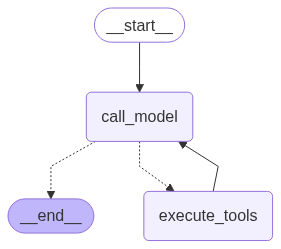

In [69]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# LangGraph MessagesState 사용
class GraphState(MessagesState):
    pass

# 노드 구성 
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: GraphState):
    last_message = state["messages"][-1]
    # 도구 호출이 있으면 도구 실행 노드로 이동
    if last_message.tool_calls:
        return "execute_tools"
    # 도구 호출이 없으면 답변 생성하고 종료 
    return END

# 그래프 구성
builder = StateGraph(GraphState)
builder.add_node("call_model", call_model)
builder.add_node("execute_tools", ToolNode(tools))

builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model", 
    should_continue,
    {
        "execute_tools": "execute_tools",
        END: END
    }
)
builder.add_edge("execute_tools", "call_model")

graph = builder.compile()
print(type(graph))

# 그래프 출력 
display(Image(graph.get_graph().draw_mermaid_png()))

In [70]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="에이드의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

에이드의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_6ecbjQHKMfn9Qpx4dv8C6vsz)
 Call ID: call_6ecbjQHKMfn9Qpx4dv8C6vsz
  Args:
    query: 에이드
================================= Tool Message =================================
Name: search_menu

[Document(id='d998f486-c3bb-404e-9030-7eb9d0842e61', metadata={'source': '../data/cafe_menu_data.txt', 'menu_number': 2, 'menu_name': '카페라떼'}, page_content='2. 카페라떼\n   • 가격: ₩5,500\n   • 주요 원료: 에스프레소, 스팀 밀크\n   • 설명: 진한 에스프레소에 부드럽게 스팀한 우유를 넣어 만든 대표적인 밀크 커피입니다. 크리미한 질감과 부드러운 맛이 특징이며, 다양한 시럽과 토핑 추가가 가능합니다. 라떼 아트로 시각적 즐거움도 제공합니다.'), Document(id='774beead-0fee-466d-9bb6-28b79dd2e4b7', metadata={'source': '../data/cafe_menu_data.txt', 'menu_number': 7, 'menu_name': '프라푸치노'}, page_content='7. 프라푸치노\n   • 가격: ₩7,000\n   • 주요 원료: 에스프레소, 우유, 얼음, 휘핑크림\n   • 설명: 에스프레소와 우유, 얼음을 블렌더에 갈아 만든 시원한 음료입니다. 부드럽고

- tools condition 활용하기

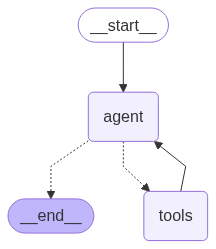

In [71]:
from langgraph.prebuilt import tools_condition

# 노드 함수 정의
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 그래프 구성
builder = StateGraph(GraphState)

builder.add_node("agent", call_model)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "agent")

# tools_condition을 사용한 조건부 엣지 추가
builder.add_conditional_edges(
    "agent",
    tools_condition,
)

builder.add_edge("tools", "agent")

graph = builder.compile()

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [72]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="카페에 에이드 종류는 무엇이 있나요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

카페에 에이드 종류는 무엇이 있나요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_pszQ4KeOgpXKWRJw0bZdPuW9)
 Call ID: call_pszQ4KeOgpXKWRJw0bZdPuW9
  Args:
    query: 에이드
================================= Tool Message =================================
Name: search_menu

[Document(id='d998f486-c3bb-404e-9030-7eb9d0842e61', metadata={'source': '../data/cafe_menu_data.txt', 'menu_number': 2, 'menu_name': '카페라떼'}, page_content='2. 카페라떼\n   • 가격: ₩5,500\n   • 주요 원료: 에스프레소, 스팀 밀크\n   • 설명: 진한 에스프레소에 부드럽게 스팀한 우유를 넣어 만든 대표적인 밀크 커피입니다. 크리미한 질감과 부드러운 맛이 특징이며, 다양한 시럽과 토핑 추가가 가능합니다. 라떼 아트로 시각적 즐거움도 제공합니다.'), Document(id='774beead-0fee-466d-9bb6-28b79dd2e4b7', metadata={'source': '../data/cafe_menu_data.txt', 'menu_number': 7, 'menu_name': '프라푸치노'}, page_content='7. 프라푸치노\n   • 가격: ₩7,000\n   • 주요 원료: 에스프레소, 우유, 얼음, 휘핑크림\n   • 설명: 에스프레소와 우유, 얼음을 블렌더에 갈아 만든 시원한 음료입니다.

- MemorySaver

In [73]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 초기화 
memory = MemorySaver()

# 체크포인터 지정하여 그래프 컴파일 
graph_memory = builder.compile(checkpointer=memory)

In [74]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="에이드 가격은 얼마인가요?")]
messages = graph_memory.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

에이드 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_I8KalgCR5Nj6JcaKdx28w2Q2)
 Call ID: call_I8KalgCR5Nj6JcaKdx28w2Q2
  Args:
    query: 에이드
================================= Tool Message =================================
Name: search_menu

[Document(id='d998f486-c3bb-404e-9030-7eb9d0842e61', metadata={'source': '../data/cafe_menu_data.txt', 'menu_number': 2, 'menu_name': '카페라떼'}, page_content='2. 카페라떼\n   • 가격: ₩5,500\n   • 주요 원료: 에스프레소, 스팀 밀크\n   • 설명: 진한 에스프레소에 부드럽게 스팀한 우유를 넣어 만든 대표적인 밀크 커피입니다. 크리미한 질감과 부드러운 맛이 특징이며, 다양한 시럽과 토핑 추가가 가능합니다. 라떼 아트로 시각적 즐거움도 제공합니다.'), Document(id='774beead-0fee-466d-9bb6-28b79dd2e4b7', metadata={'source': '../data/cafe_menu_data.txt', 'menu_number': 7, 'menu_name': '프라푸치노'}, page_content='7. 프라푸치노\n   • 가격: ₩7,000\n   • 주요 원료: 에스프레소, 우유, 얼음, 휘핑크림\n   • 설명: 에스프레소와 우유, 얼음을 블렌더에 갈아 만든 시원한 음료입니다. 부드럽고 

In [75]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="그 중에 가장 저렴한 메뉴는 무엇인가요?")]
messages = graph_memory.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

에이드 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_I8KalgCR5Nj6JcaKdx28w2Q2)
 Call ID: call_I8KalgCR5Nj6JcaKdx28w2Q2
  Args:
    query: 에이드
================================= Tool Message =================================
Name: search_menu

[Document(id='d998f486-c3bb-404e-9030-7eb9d0842e61', metadata={'source': '../data/cafe_menu_data.txt', 'menu_number': 2, 'menu_name': '카페라떼'}, page_content='2. 카페라떼\n   • 가격: ₩5,500\n   • 주요 원료: 에스프레소, 스팀 밀크\n   • 설명: 진한 에스프레소에 부드럽게 스팀한 우유를 넣어 만든 대표적인 밀크 커피입니다. 크리미한 질감과 부드러운 맛이 특징이며, 다양한 시럽과 토핑 추가가 가능합니다. 라떼 아트로 시각적 즐거움도 제공합니다.'), Document(id='774beead-0fee-466d-9bb6-28b79dd2e4b7', metadata={'source': '../data/cafe_menu_data.txt', 'menu_number': 7, 'menu_name': '프라푸치노'}, page_content='7. 프라푸치노\n   • 가격: ₩7,000\n   • 주요 원료: 에스프레소, 우유, 얼음, 휘핑크림\n   • 설명: 에스프레소와 우유, 얼음을 블렌더에 갈아 만든 시원한 음료입니다. 부드럽고 

- 내장 ReAct 사용

In [ ]:
config = {"configurable": {"thread_id": "2"}}

messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content="채식주의자를 위한 음료 메뉴가 있나요?")
    ]

messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_menu  
액션 입력: 스테이크  

(도구 실행 후)  
[출처: search_menu | 카페라떼 | ../data/menu.txt]  
카페라떼 정보: 5,000원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성

================================ Human Message =================================

채식주의자를 위한 음료 메뉴가 있나요?
================================== Ai Message ==================================
Tool Calls:
  search_men

In [77]:
config = {"configurable": {"thread_id": "2"}}
messages = [HumanMessage(content="방금 답변에 대한 출처가 있나요?")]
messages = graph.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

방금 답변에 대한 출처가 있나요?
================================== Ai Message ==================================

제가 말씀드린 내용은 질문하신 내용에 대한 정보 업데이트가 진행되지 않았으므로, 출처가 없습니다. 질문이 있으시면 더 상세히 답변드리겠습니다.


In [79]:
config = {"configurable": {"thread_id": "2"}}

messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content="카페 인기 메뉴 추천해줘")
    ]

messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_menu  
액션 입력: 스테이크  

(도구 실행 후)  
[출처: search_menu | 카페라떼 | ../data/menu.txt]  
카페라떼 정보: 5,000원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성

================================ Human Message =================================

카페 인기 메뉴 추천해줘
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_